# Projet AFD - Lothair KIZARDJIAN

# Première partie : Régression linéaire.

Je vais d'abord commencer par importer les bibliothèques nécessaires puis je vais procéder à un nettoyage des données.
Premièrement supprimer les colonnes que je juge inutiles pour prédire le champ rating et ensuite supprimer certaines lignes car d'après ce que j'ai pu voir beaucoup de lignes possèdent des valeurs qui sont nulles.

In [2]:
import scipy
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('googleplaystore.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [3]:
# Suppression des colonnes inutiles car données non significatives

data.drop(labels = ['Last Updated','Current Ver','Android Ver','App','Size'], axis = 1, inplace = True)
data.dropna(inplace=True) #suppression des lignes qui ne possèdent pas de valeurs
data = data[data["Rating"]!= 19] #suprression de la ligne décallée
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 8 columns):
Category          9366 non-null object
Rating            9366 non-null float64
Reviews           9366 non-null object
Installs          9366 non-null object
Type              9366 non-null object
Price             9366 non-null object
Content Rating    9366 non-null object
Genres            9366 non-null object
dtypes: float64(1), object(7)
memory usage: 658.5+ KB


Plus aucune ligne n'a de valeur manquante. Cependant les colonnes sont de type "object" je vais donc les modifier en integer pour pouvoir travailler avec.

Je vais maintenant procéder à un nettoyage des données afin de pouvoir travailler avec, il me faut des colonnes qui soient de type int ou float.

In [4]:
#Suppression des ',' et des '+' dans les lignes de installs afin de ne pas avoir par exemple 10,000+ mais 10000
data["Installs"] = data["Installs"].map(lambda x: int(x.replace(",","").replace("+",""))).astype(np.int)

In [5]:
#Suppression des '$' dans les lignes de Price afin de ne pas avoir par exemple 4.92$ mais 4.92
data["Price"] = data["Price"].map(lambda x: float(x.replace("$",""))).astype(np.float32)

In [6]:
name_y  = ["Rating"]  #Stockage des étiquettes
name_x_quantitative = ["Installs", "Price","Reviews"]
name_x_qualitative = ["Category", "Type","Content Rating"]

Ici j'ai remarqué que certainnes colonnes sont des variables qualitatives donc il faut pour chaque valeur unique de ces variables créer une nouvelle variable où l'ont met 1 dans la valeur de la nouvelle variable correspondante et 0 dans les autres, c'est à cela que sert le pd.get_dummies.

Finalement je vais centrer et réduire mes données car certaines variables possèdent des valeur max très grandes et donc pourraient avoir un poids bien plus fort que d'autres variables

In [7]:
y = data[name_y].values
#colle les deux matrices (data[name_x_quantitative].values) et (pd.get_dummies(data[name_x_qualitative]).values)
X = np.hstack((data[name_x_quantitative].values, pd.get_dummies(data[name_x_qualitative]).values)).astype(np.float32)

#Permet de centrer et réduire une matrice
sc = StandardScaler()
Z = sc.fit_transform(X)

In [8]:
print(np.mean(Z,axis=0))

[-1.6291681e-09 -8.9604253e-09 -3.2583363e-09 -3.3397946e-08
 -4.0729203e-10 -6.5166725e-09 -2.9325028e-08  1.4255222e-08
 -5.7020886e-09 -2.4437522e-08 -1.7920851e-08  0.0000000e+00
  0.0000000e+00 -8.5531333e-09  1.0426676e-07  1.6291681e-08
 -6.5166725e-09 -1.3847929e-08 -1.9550018e-08  4.8875046e-09
 -1.2218761e-08  1.1302355e-08 -9.3677173e-09  3.2583363e-09
  1.2218761e-08  8.1458404e-09  1.7920851e-08  1.3847929e-08
  1.3847929e-08 -8.1458404e-09 -1.2218762e-09 -6.5166725e-09
  6.4352143e-08 -2.4641169e-08  2.1179186e-08 -1.7106267e-08
  6.5166725e-09 -6.5166725e-09  4.4802126e-09  2.0364601e-09
 -1.2218761e-08 -9.7750092e-09 -6.5166725e-09  3.6656285e-09]


La matrice est bien centrée, chaque moyenne est égale à 0 ou bien un valeur très proche de 0 (e-09 est considéré comme étant 0)

In [9]:
print(np.std(Z,axis=0))

[1.         0.99999976 0.99999994 1.         1.         1.
 1.         0.9999999  1.         0.9999999  1.         0.9999998
 1.         0.9999999  1.         1.         1.         1.
 0.99999994 0.99999994 0.9999999  1.0000001  1.         1.
 1.         1.         1.0000001  1.         0.99999994 1.
 0.9999999  1.0000001  1.0000001  1.         1.         1.
 1.         1.         0.9999998  1.         1.         1.
 1.         1.        ]


La matrice est bien réduite, chaque variance est égale à 1 ou une valeur très proche de 1

In [10]:
Z.shape

(9366, 44)

In [11]:
y.shape

(9366, 1)

In [12]:
lr = LinearRegression(normalize=True)
pca = PCA(n_components=1)
z_pca = pca.fit_transform(Z)

In [13]:
print(pca.explained_variance_ratio_)

[0.05502758]


On peux voir que faire une ACP pour obtenir une dimension 1 depuis les 44 initiales ne permet de retenir que 5% de l'information. Il est très compliqué de pouvoir dire à quoi correspond la dimension que l'ACP a produite.

C:\Users\ADMIN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


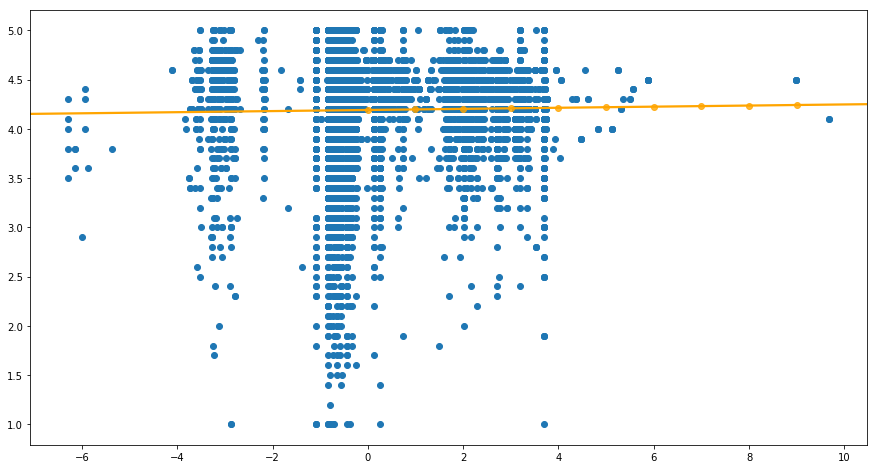

In [14]:
plt.figure(figsize=(15,8))
plt.scatter(z_pca, y)
lr.fit(Z,y)
tab = (np.array(list(range(0,10,1)))).reshape((-1,1))
tab_pca = pca.inverse_transform(tab)
pred = lr.predict(tab_pca)
sns.regplot(tab[:,0],pred[:,0],color='orange')

On peut cependant voir que la régression linéaire qui a été effectué ne permet de faire de bonne predictions. En orange c'est la courbe de la regression linéaire obtenue après avoir prédit des exemples en dimension 1 de 0 à 10 qui ont ensuite été retransformés en dimension 44 via l'ACP. La courbe ne correspond pas du tout au nuage de point, on peut donc dire qu'une régression linéaire n'est pas la bonne méthode pour prédire le champ rating, mais peut être qu'une régression polynomiale serait plus efficace.

# Partie 2 : K-means,mixture gaussienne,k-NN,Bayes,regression logistique.

# Kmeans

In [15]:
from sklearn.cluster import KMeans

data_students = pd.read_csv('StudentsPerformance.csv')
data_students.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


De même pour ce jeu de donnée je vais le modifier afin de pouvoir travailler avec, càd modifier les colonnes qui sont de type object en int ou float et créer les dummies pour les variables qui sont qualitatives.

In [16]:
data_students["lunch"] = data_students["lunch"].map(lambda x: 1 if x=="standard" else 0).astype(np.int)

In [17]:
data_students["parental level of education"] = data_students['parental level of education'].map(
    lambda x:
        0 if x=="some high school" else
        1 if x=="high school" else
        2 if x=="some college" else
        3 if x=="associate's degree" else
        4 if x=="bachelor's degree" else
        5
    ).astype(np.int)

In [18]:
name_x_students_qualitative = ['gender','race/ethnicity','test preparation course']
name_x_students_quantitative= ['math score','reading score','writing score','lunch','parental level of education']
X_students = pd.concat([pd.get_dummies(data_students[name_x_students_qualitative]),
                        data_students[name_x_students_quantitative]],axis=1)

Il faut maintenant déterminer le nombre optimal de cluster. Pour cela je vais utiliser la méthode du "coude", càd que je vais effectuer Kmeans avec un k croissant et je vais à chaque fois calculer l'intertie pour ce kmeans qui est la somme des distances au carré de chaque échantillon par rapport au centre du cluster dans lequel il se trouve.

Une intertie plus faible indique un meilleur clustering, cependant plus on augmentera le nombre de cluster plus l'intertie diminuera mais elle ne diminuera plus significativement, il faut donc trouver le nombre de cluster qui correspond au moment ou l'intertie arrête de diminuer drastiquement. 

C'est à cela que sert la méthode du "coude" : pour chaque nombre de cluster k, on affichera l'intertie sur un graphique et on déterminera le nombre de cluster optimal.

In [19]:
Inerties = []
K_range = range(1,30)
for k in K_range:
    k_means = KMeans(n_clusters=k)
    k_means = k_means.fit(X_students)
    Inerties.append(k_means.inertia_)

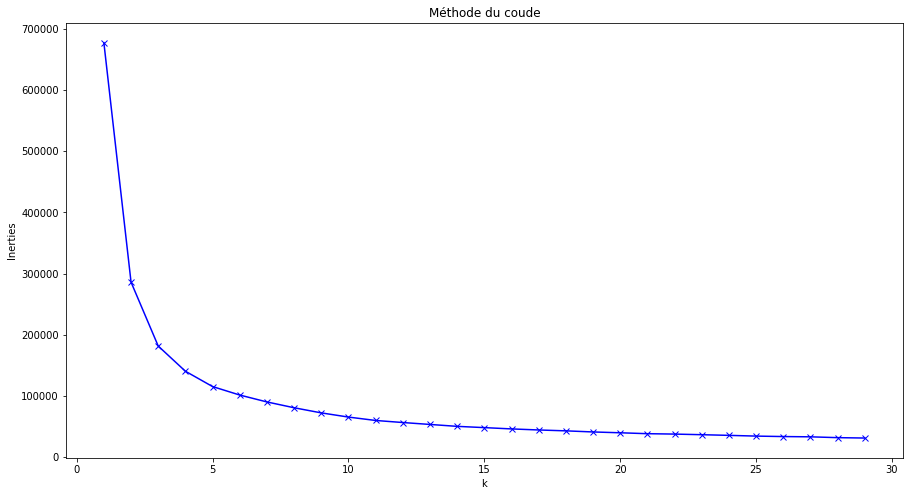

In [20]:
plt.figure(figsize=(15,8))
plt.plot(K_range, Inerties, 'bx-')
plt.xlabel('k')
plt.ylabel('Inerties')
plt.title('Méthode du coude')
plt.show()

On peut voir que l'inertie arrête de diminuer de manière significative à partir d'environs 3 clusters. 
Je vais donc utiliser 3 clusters pour Kmeans et analyser les données à partir de ces clusters.

In [21]:
k_means_opt = KMeans(n_clusters = 3)
k_means_opt = k_means_opt.fit(X_students)
prediction  = k_means_opt.predict(X_students)
data_students['cluster'] = prediction

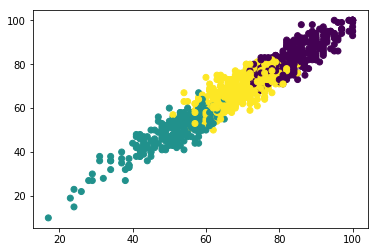

In [22]:
plt.scatter(data_students["reading score"],data_students["writing score"],c=prediction)

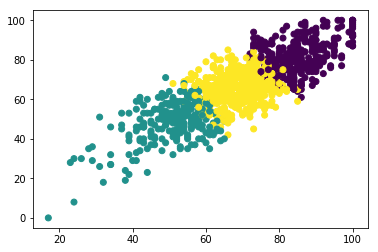

In [23]:
plt.scatter(data_students["reading score"],data_students["math score"],c=prediction)

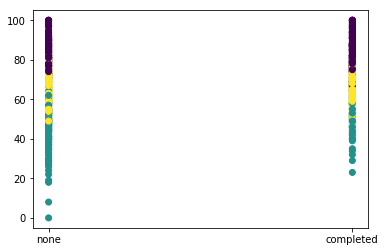

In [24]:
plt.scatter(data_students["test preparation course"],data_students["math score"],c=prediction)

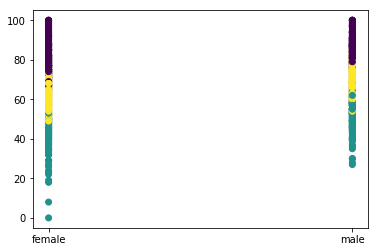

In [25]:
plt.scatter(data_students["gender"],data_students["math score"],c=prediction)

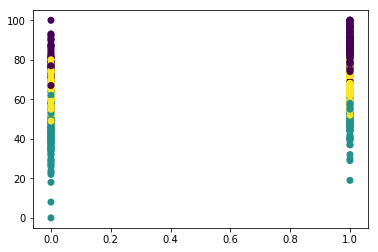

In [26]:
plt.scatter(data_students["lunch"],data_students["math score"],c=prediction)

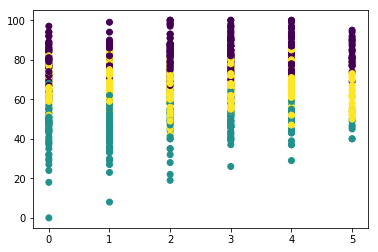

In [27]:
plt.scatter(data_students["parental level of education"],data_students["math score"],c=prediction)

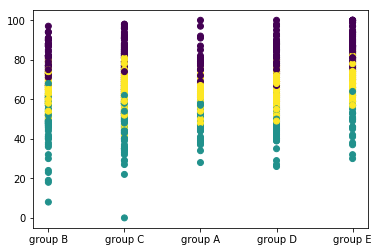

In [28]:
plt.scatter(data_students["race/ethnicity"],data_students["math score"],c=prediction)

 D'après ce clustering on peux tirer plusieurs conclusions :
- Premièrment les 3 clusters formés semblent définir 3 groupes d'étudiants : ceux qui ont de mauvais scores, ceux qui ont des scores moyens et ceux qui ont des bons scores.
- Les clusters ont l'air de dépendre uniquement des scores car chaque autre variable non continue ne permet pas de trouver des critères propre à un cluster en particulier.

Peut être qu'en effectuant une ACP en 2 dimensions il sera possible de faire une analyse un peu plus détaillée

In [29]:
#centrage réduction
sc = StandardScaler()
Z_students = sc.fit_transform(X_students)

C:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
print(np.mean(Z_students,axis=0))

[-4.26325641e-17  4.26325641e-17 -4.44089210e-18  0.00000000e+00
  6.92779167e-17 -3.55271368e-17 -2.84217094e-17 -3.37507799e-17
  3.37507799e-17  8.70414851e-17  2.16715534e-16 -1.35003120e-16
 -1.95399252e-17 -1.06581410e-17]


In [31]:
print(np.std(Z_students,axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
pca_students = PCA(n_components=2)
data_students_pca = pca_students.fit_transform(Z_students)
print(pca_students.explained_variance_ratio_)

[0.23527756 0.15263883]


Avec 2 composants on garde 28% de l'information. Mais il est possible d'afficher les vecteurs de chaque variable sur la figure ce qui permet demieux visualiser ce à quoi correspondent les clusters.

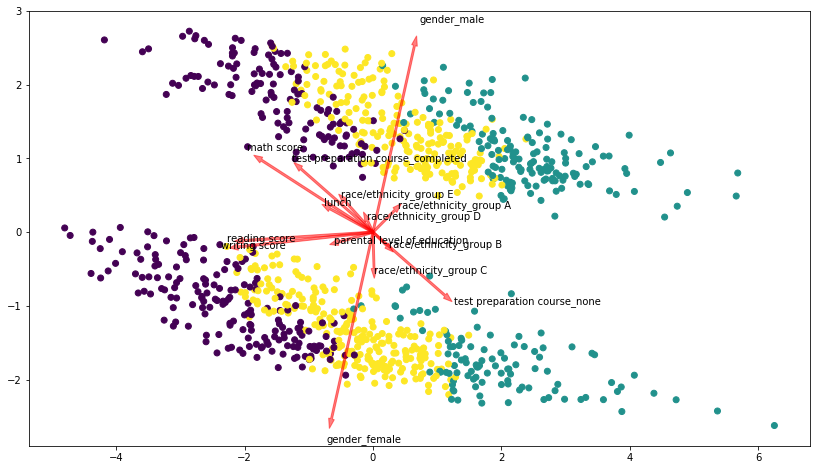

In [33]:
fig, ax = plt.subplots(figsize = (14,8))
ax.scatter(data_students_pca[:,0],data_students_pca[:,1],c=prediction)

#Création d'une flèche qui va représenter une variable
for i, ev in enumerate(pca_students.components_.T): 
    plt.arrow(0, 0, 4*ev[0], 4*ev[1],color = 'r',width=0.03,alpha = 0.5)
    plt.text(ev[0]* 4.5, ev[1] * 4.5,X_students.columns[i])

Grâce à cette représentation une analyse plus poussée est possible. Analyson l'impact de chaque variable sur les notes:

-être un garçon ou une fille ne présente aucun impact.
-l'ethnicité ne présente pas d'impact non plus.
-le 'lunch' par contre montre que ceux ayant un forfait standard on plus réussi, donc est-ce que les riches sont privilégiés ?
-les élèves ayant passé 'test praparation course' ont de biens meilleurs résultats.
-le parental level of education n'a pas l'air de présenter d'impact.

# Mixture Gaussienne

Pour déterminer le nombre de components optimal il faut trouver pour quel nombre de components le BIC (Bayesion Information Criterion) est le plus bas, j'aurai pu me contenter de la LikeliHood mais le BIC est plus précis car il ajoute des points de pénalité.

9


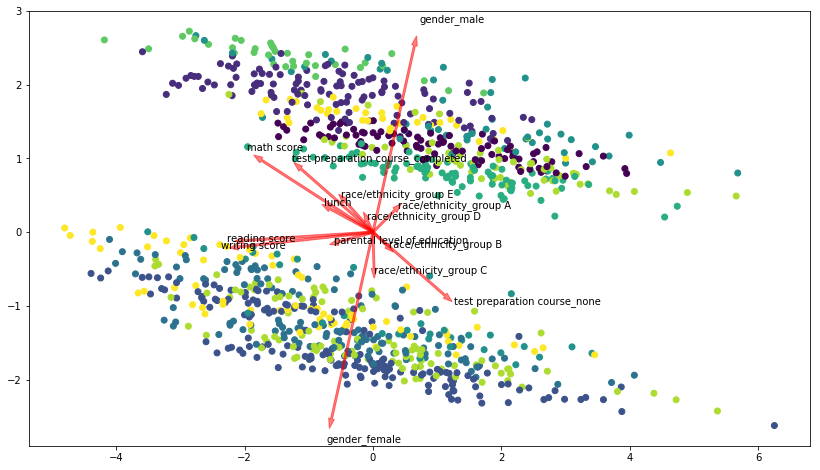

In [60]:
from sklearn import mixture

n = 20
n_compo_bics = np.zeros((n,1))
n_components_range = range(1,n)

for i in range(1,50):
    lowest_bic = np.infty
    """
    car le bic varie même pour un n_components fixé, 
    donc je teste plusieurs fois le BIC, le n_components 
    pour lequel le BIC est le minimum le plus de fois est choisi.
    """
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type="full")
        gmm.fit(Z_students)
        bic = gmm.bic(Z_students)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
            n_compo_bics[n_components] += bic

best_n_compo = 0
min = np.infty
k = 0
for i in n_compo_bics:
    if i < min:
        min = i
        best_n_compo = k
    k+=1

print(best_n_compo)
best_gmm = mixture.GaussianMixture(n_components=best_n_compo,covariance_type="full")
prediction= best_gmm.fit_predict(Z_students)
fig, ax = plt.subplots(figsize = (14,8))
ax.scatter(data_students_pca[:,0],data_students_pca[:,1],c=prediction)

#Création d'une flèche qui va représenter une variable
for i, ev in enumerate(pca_students.components_.T): 
    plt.arrow(0, 0, 4*ev[0], 4*ev[1],color = 'r',width=0.03,alpha = 0.5)
    plt.text(ev[0]* 4.5, ev[1] * 4.5,X_students.columns[i])

J'ai effectué plusieurs test et le meilleurs nombre n_components varie toujours donc je n'arrive pas à savoir lequel est le meilleur. La plupart du temps c'est un n_components >= 8 et il est très difficile d'analyser ce nuage de points. Donc je ne sais pas trop quoi analyser.

# K-PPV 

In [70]:
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [71]:
score_median = data_students["math score"].median()

On va chercher à prédire si le math score de chaque point est supérieur au score médian grâce au score de ses k-ppv.
Je vais donc d'abord implémenter l'algo des kppv(individu i, voisins k)

In [72]:
def predict_with_kppv(x, X, y, k):
    indexes = list(range(len(X)))
    indexes.sort(key=lambda i: hamming_distance(X[i], x))
    classes = {classe: 0 for classe in np.unique(y)}
    for index in indexes[:k]:
        classes[y[index]] += 1
    return max(classes.keys(), key=lambda k: classes[k])

In [73]:
X_students_array = data_students.values
Y_students_array = []
for i in range(0,len(X_students_array)):
    if data_students["math score"].iloc[i] > score_median:
        Y_students_array = np.append(Y_students_array, [1])   
    else :
        Y_students_array = np.append(Y_students_array, [0]) 

In [98]:
good_predictions = 0
for index in range(len(data_students)):
    prediction = predict_with_kppv(X_students_array[index], 
                                   np.delete(X_students_array,index,0),
                                   np.delete(Y_students_array,index,0), 1)
    if prediction == Y_students_array[index]:
        good_predictions+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_predictions,len(X_students_array),good_predictions*100/len(X_students_array)))

 862 bonnes prédiction sur 1000, soit 86.2% de bonnes prédiction


Pour un 1-PPV 86.2% de bonnes prédiction n'est pas trop mal mais le modèle peut clairement être amélioré

# Naive Bayes

In [77]:
def naive_bayes_classifer(X,y,x):
    proba_classes = {}
    for c in np.unique(y):
        P_y = sum(y[y[:]==1])/len(y)
        x_corresponding_to_y = [X[i] for i in range (0,len(X)) if y[i] == c]
        P_x_sachant_y = 1
        for i in range(len(x)):
            P_x_sachant_y *= sum(1 for x_i in x_corresponding_to_y if x_i[i] == x[i]) / len(x_corresponding_to_y)
        proba_classes[c] = P_y * P_x_sachant_y
    return max(proba_classes, key = lambda k: proba_classes[k])

In [97]:
good_predictions_naive_bayes = 0

X_students_array_bayes = data_students[['gender','race/ethnicity','test preparation course','parental level of education','lunch']].values


for index in range(len(X_students_array_bayes)):
    prediction = naive_bayes_classifer(np.delete(X_students_array_bayes,index,0), 
                                       np.delete(Y_students_array,index,0),
                                       X_students_array_bayes[index])
                                   
    if prediction == Y_students_array[index]:
        good_predictions_naive_bayes+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_predictions_naive_bayes,len(X_students_array),good_predictions_naive_bayes*100/len(X_students_array)))

 646 bonnes prédiction sur 1000, soit 64.6% de bonnes prédiction


Ici 64.6% de bonnes prédiction indique vraiment que notre classifieur n'est pas adapté donc l'hypothèse naive ne fonctionne pas car beaucoup de variables ne doivent pas être indépendantes. Pour observer cela on peut essayer de visualiser la matrice de corrélation des données.

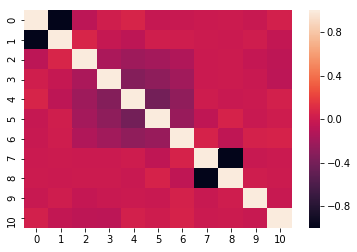

In [343]:
X_student_bayes_continuous = X_students.drop(columns=['math score', 'reading score','writing score']).values
X_student_bayes_continuous_centered = X_student_bayes_continuous-np.mean(X_student_bayes_continuous,axis=0)
X_student_bayes_continuous_centered_reduced = X_student_bayes_continuous_centered * (1/np.std(X_student_bayes_continuous_centered,axis=0))
X_student_bayes_continuous_correlation_matrix = (1/len(X_student_bayes_continuous) * np.dot(np.transpose(X_student_bayes_continuous_centered_reduced),X_student_bayes_continuous_centered_reduced))
sns.heatmap(X_student_bayes_continuous_correlation_matrix)

On observe beaucoup de covariances qui sont très proches de 0 cela peut indiquer que les variables concernées sont indépendantes mais ce n'est pas sûr. Cependant on remarque les variables 0 et 1 (resp. $gender\_female$ et $gender\_male$) sont très fortement corrélées ainsi que les variables 7 et 8 (resp. $test\ preparation\ course\_completed$ et $test\ preparation\ course\_none$. On remarque un autre groupe qui concerne les variables de 2 à 6 qui correspondent aux variables de $race\_ethnicity$ et qui sont quelque peu corrélées.

On peux en déduire que, de ce fait, utiliser l'hypothèse naive n'est pas forcément une bonne idée.

# Gaussian Naive Bayes

On cherche à prédire si le 'math score' est supérieur au score médian on est donc dans un cas bi-classe : y = 1 si le 'math score' est supérieur au score médian et 0 sinon. On a donc $P(X=x_i | Y=y)$ qui suit une loi normale.
<br>
Donc le classifieur optimal est:
<br>
<br>
$h(x) = argmax_c P(Y=c | X=x_i)$
<br>
$h(x) = argmax_c \sum_{j=1}^d \left( - \log \sigma_{c,j} - \frac{1}{2}\left( \frac{x^j - \mu_{c,j}}{\sigma_{c,j}} \right)^2 \right) + \log\left( \pi_c \right)$ 
<br>
<br>
Donc dans notre cas on classe $x$ dans $1$ si
<br>
$\sum_{j=1}^d \left( - \log \sigma_{1,j} - \frac{1}{2}\left( \frac{x^j - \mu_{1,j}}{\sigma_{1,j}} \right)^2 \right) + \log\left( \pi_1 \right) > \sum_{j=1}^d \left( - \log \sigma_{0,j} - \frac{1}{2}\left( \frac{x^j - \mu_{0,j}}{\sigma_{0,j}} \right)^2 \right) + \log\left( \pi_0 \right)$
<br>
et $0$ sinon

In [344]:
from numpy.linalg import inv

X_student_gaussian_naive_bayes = X_students[['reading score', 'writing score']]
y = pd.DataFrame([1 if i > score_median else 0 for i in X_students.loc[:, "math score"]],columns=['y'],dtype=np.int32)
X_student_gaussian_naive_bayes.insert(2, "y", y.values, True) 

X_student_gaussian_naive_bayes_0 = [x for x in X_student_gaussian_naive_bayes.loc[:,'reading score':'y'].values if x[2]==0 ]
X_student_gaussian_naive_bayes_1 = [x for x in X_student_gaussian_naive_bayes.loc[:,'reading score':'y'].values if x[2]==1 ]

X_student_gaussian_naive_bayes_0 = np.delete(X_student_gaussian_naive_bayes_0, 2, 1)
X_student_gaussian_naive_bayes_1 = np.delete(X_student_gaussian_naive_bayes_1, 2, 1)

In [345]:
def gaussian_naive_bayes_classifer_biclass(µ_1,µ_0,π_1,π_0,σ_1,σ_0,x):
    A,B=0,0
    for j in range(len(x)):
        A += (-np.log(σ_1[j]) - (1/2)*np.power(((x[j] - µ_1[j])/σ_1[j]),2) + np.log(π_1))
    for j in range(len(x)):
        B += (-np.log(σ_0[j]) - (1/2)*np.power(((x[j] - µ_0[j])/σ_0[j]),2) + np.log(π_0)) 
    if A > B :
        return 1
    else:
        return 0
    

In [430]:
good_predictions_gaussian_naive_bayes = 0
µ_1 = np.mean(X_student_gaussian_naive_bayes_1 ,axis=0)
µ_0 = np.mean(X_student_gaussian_naive_bayes_0 ,axis=0)
π_1 = len(X_student_gaussian_naive_bayes_1)/len(X_student_gaussian_naive_bayes)
π_0 = len(X_student_gaussian_naive_bayes_0)/len(X_student_gaussian_naive_bayes)
σ_1 = np.std(X_student_gaussian_naive_bayes_1 ,axis=0)
σ_0 = np.std(X_student_gaussian_naive_bayes_0 ,axis=0)

for x in X_student_gaussian_naive_bayes.values :
    prediction = gaussian_naive_bayes_classifer_biclass(µ_1,µ_0,π_1,π_0,σ_1,σ_0,np.delete(x,2,0))
    if prediction == x[2]:
        good_predictions_gaussian_naive_bayes+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_predictions_gaussian_naive_bayes,len(X_students_array),good_predictions_gaussian_naive_bayes*100/len(X_students_array)))

 788 bonnes prédiction sur 1000, soit 78.8% de bonnes prédiction


On a avec cette méthode de bien meilleurs résultats, mais 78.8% n'est pas encore un très bon score car les variables ne doivent pas être indépendantes, vérifions le avec une heatmap.

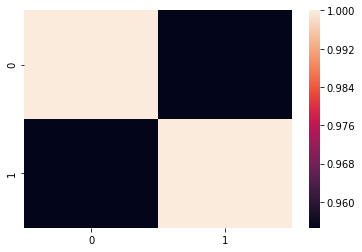

In [350]:
X_student_gaussian_naive_bayes_2 = X_students[['reading score', 'writing score']]
X_student_gaussian_naive_bayes_centered = X_student_gaussian_naive_bayes_2-np.mean(X_student_gaussian_naive_bayes_2,axis=0)
X_student_gaussian_naive_bayes_centered_reduced = X_student_gaussian_naive_bayes_centered * (1/np.std(X_student_gaussian_naive_bayes_centered,axis=0))
X_student_gaussian_naive_bayes_correlation_matrix = (1/len(X_student_gaussian_naive_bayes_2) * np.dot(np.transpose(X_student_gaussian_naive_bayes_centered_reduced),X_student_gaussian_naive_bayes_centered_reduced))
sns.heatmap(X_student_gaussian_naive_bayes_correlation_matrix)

En effet, en visualisant cette heatmap on peux clairement dire que les variables "reading score" et "writing score" sont corrélées et donc l'hypothèse naive bayes et mauvaise dans ce cas. Mais un taux de bonnes prédiction de 78,8% n'est pas mauvais alors que l'hypothèse de départ est éronnée.

# Régression logistique

Il faut appliquer la régression logistique pour ce même problème de prédiction donc je suppose qu'il faut le faire sur les 2 autres variables continues $reading\ score$ et $writing\ score$

In [483]:
good_prediction_reglog = 0
from sklearn.linear_model import LogisticRegression
Y_regLog = y.values.ravel()

In [484]:
good_prediction_reglog = 0
X_regLog_1 = pd.get_dummies(data_students[name_x_students_qualitative]).values
regLog = LogisticRegression(random_state=0, solver='liblinear').fit(X_regLog_1, Y_regLog)
for x in X_regLog_1 :
    prediction = regLog.predict(x.reshape(1,-1))
    if prediction == x[2]:
        good_prediction_reglog+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_prediction_reglog,len(X_regLog_1),good_prediction_reglog*100/len(X_regLog_1)))

 532 bonnes prédiction sur 1000, soit 53.2% de bonnes prédiction


In [485]:
good_prediction_reglog = 0
X_regLog_2 = X_students[['reading score', 'writing score']]
regLog = LogisticRegression(random_state=0, solver='liblinear').fit(X_regLog_2, Y_regLog)
X_regLog_2.insert(2, "y", Y_regLog, True) 
for x in X_regLog_2.values:
    prediction = regLog.predict(np.delete(x,2,0).reshape(1,-1))
    if prediction == x[2]:
        good_prediction_reglog+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_prediction_reglog,len(X_regLog_2),good_prediction_reglog*100/len(X_regLog_2)))

 794 bonnes prédiction sur 1000, soit 79.4% de bonnes prédiction


In [492]:
good_prediction_reglog = 0
X_regLog = np.concatenate((X_regLog_1,X_regLog_2.values),axis=1)
regLog = LogisticRegression(random_state=0, solver='liblinear').fit(np.delete(X_regLog,len(X_regLog[0])-1,1), Y_regLog)
for x in X_regLog:
    prediction = regLog.predict(np.delete(x,len(X_regLog[0])-1,0).reshape(1,-1))
    if prediction == x[len(X_regLog[0])-1]:
        good_prediction_reglog+=1

print(" {} bonnes prédiction sur {}, soit {}% de bonnes prédiction".format(good_prediction_reglog,len(X_regLog_2),good_prediction_reglog*100/len(X_regLog_2)))

 872 bonnes prédiction sur 1000, soit 87.2% de bonnes prédiction


Avec seulement une partie des données (donc soit $X\_regLog\_1$ soit $X\_regLog\_2$) on peut voir que la régression logistique n'offre pas de très bien résultats bien que 79.4% pour $X\_regLog\_2$ ne soit pas trop mal.
<br>
Cependant avec absolument toutes les données $X\_regLog$, la régression logistique arrive à prédire avec un taux de 87.2% ce qui est très bien mais qui est assez proche de la prédiction de $X\_regLog\_2$. On peut donc en déduire que plus on a de variables plus les précisions sont exactes (si ces variables ne sont pas du bruit) mais on remarque que surtout les variables correspondant à $reading\ score$ et à $writing\ score$ sont les plus importantes.